# The purpose of this notebook is to get more knowledge about these datasets

In [151]:
## run with eda_env 
##TODO - EDA -> try to build features by heuristics and then build model ?? -> super easy and cool
##TODO -> Get to know data better. Actually data analysis is where we should start

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
import spacy

## Most occuring words in clickbaits and no-clikbaits

In [153]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced.csv")

In [154]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

In [155]:
x_train_clickbait = x_train[y_train==1]
x_train_no_clickbait = x_train[y_train==0]

In [156]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [157]:
def get_most_common_words(x_train):
    # Docstring ...
    words = x_train.str.split().explode().tolist()
    words_no_stop_words = [word.lower() for word in words if word.lower() not in stop_words]
    counter = Counter(words_no_stop_words)
    most_common_words = counter.most_common(15)
    return most_common_words
    

In [158]:
df_clibkaits = pd.DataFrame(get_most_common_words(x_train_clickbait), columns=['Word', 'Frequency'])
df_NO_clibkaits = pd.DataFrame(get_most_common_words(x_train_no_clickbait), columns=['Word', 'Frequency'])

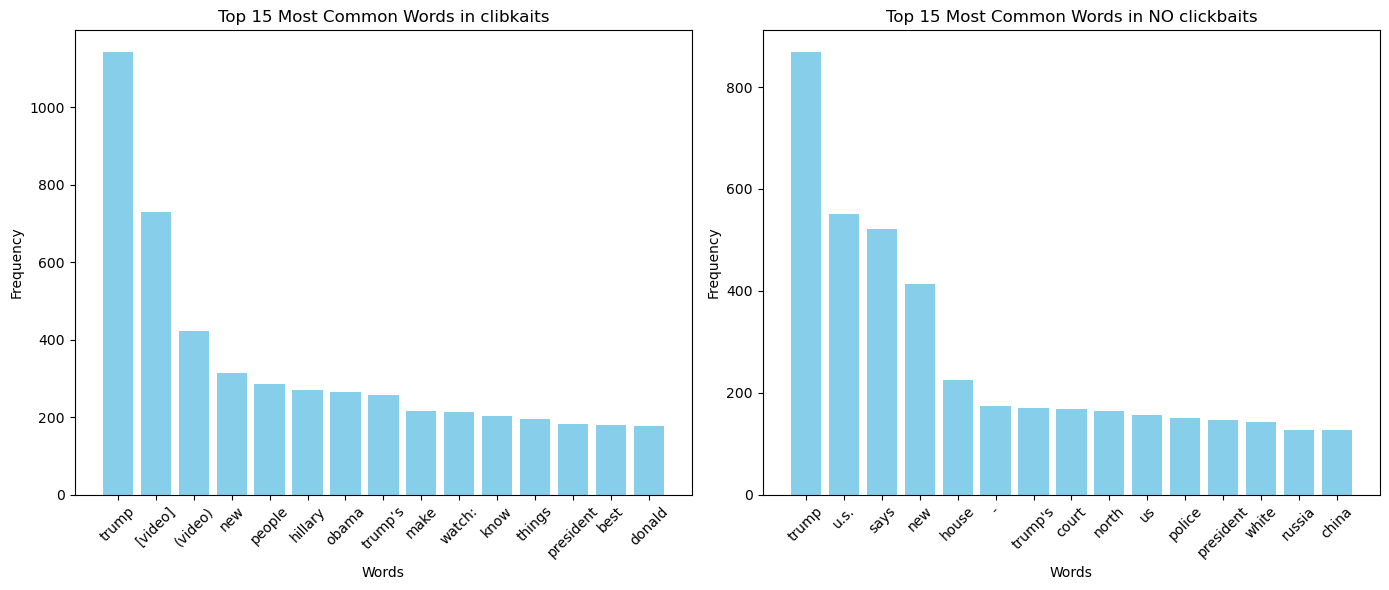

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


axes[0].bar(df_clibkaits['Word'], df_clibkaits['Frequency'], color='skyblue')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 15 Most Common Words in clibkaits')
axes[0].tick_params(axis='x', rotation=45)


axes[1].bar(df_NO_clibkaits['Word'], df_NO_clibkaits['Frequency'], color='skyblue')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 15 Most Common Words in NO clickbaits')
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

Pomysly:
- Ilość wielkich liter w tytulach z clickbaitami do wilekich liter z prawdziwymi artykulami
- Analiza znakow interpunkcyjnych
- jezyk artykulow
- semantyka artykułów - slownictwo nacechowane negatywnie/pozytywnie - sentiment analysis, czy tytuł i artykuł maja ten sam sentyment
- stopwords in articles and titles

## Named Entity Recognition (NER)
NER identifies predefined categories of words in sentences.

### Example:
*John Smith uses iPhone 11 while going to Toronto.*

- **John Smith** - Person
- **iPhone 11** - Product
- **Toronto** - Location

In [160]:
def extract_named_entities(text):
    """
    Extracts entities from text. Returns dictionary with the count of each entity type.
    """
    doc = nlp(text)
    entities = {}
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_] += 1
        else:
            entities[entity.label_] = 1.0
    return entities


In [161]:
# This cell executes up to ~3min
nlp = spacy.load('en_core_web_sm')
extracted_entities = df_merged["title"].apply(extract_named_entities)
entities_df = pd.DataFrame(list(extracted_entities))
df_merged = df_merged[["clickbait"]].join(entities_df).fillna(0.0)
grouped = df_merged.groupby("clickbait").sum()
grouped = grouped.transpose()

In [162]:
def classify(row):
    """
    vote for the option where the measurement is greater by 5%
    """
    if row[0] > 0.05 * row['total'] + row[1]:
        return 1
    elif row[1] > 0.05 * row['total'] + row[0]:
        return 0
    else:
        return 0.5

In [163]:
# ordering
grouped["total"] = grouped[0] + grouped[1]

# classification of entities as clickbait supportive or not
grouped["class"] = grouped.apply(classify, axis=1)
grouped = grouped.sort_values("total", ascending=False)
print(f"Clickbait supportive: {grouped.index[grouped['class'] == 1].to_list()}")
print(f"Neutral: {grouped.index[grouped['class'] == 0.5].to_list()}")
print(f"Valid article supportive: {grouped.index[grouped['class'] == 0].to_list()}")
grouped = grouped.drop(columns=["total", "class"])

Clickbait supportive: ['ORG', 'GPE', 'NORP', 'DATE', 'LOC', 'ORDINAL', 'PRODUCT', 'FAC', 'TIME', 'PERCENT', 'QUANTITY', 'LANGUAGE']
Neutral: ['PERSON', 'MONEY']
Valid article supportive: ['CARDINAL', 'WORK_OF_ART', 'EVENT', 'LAW']


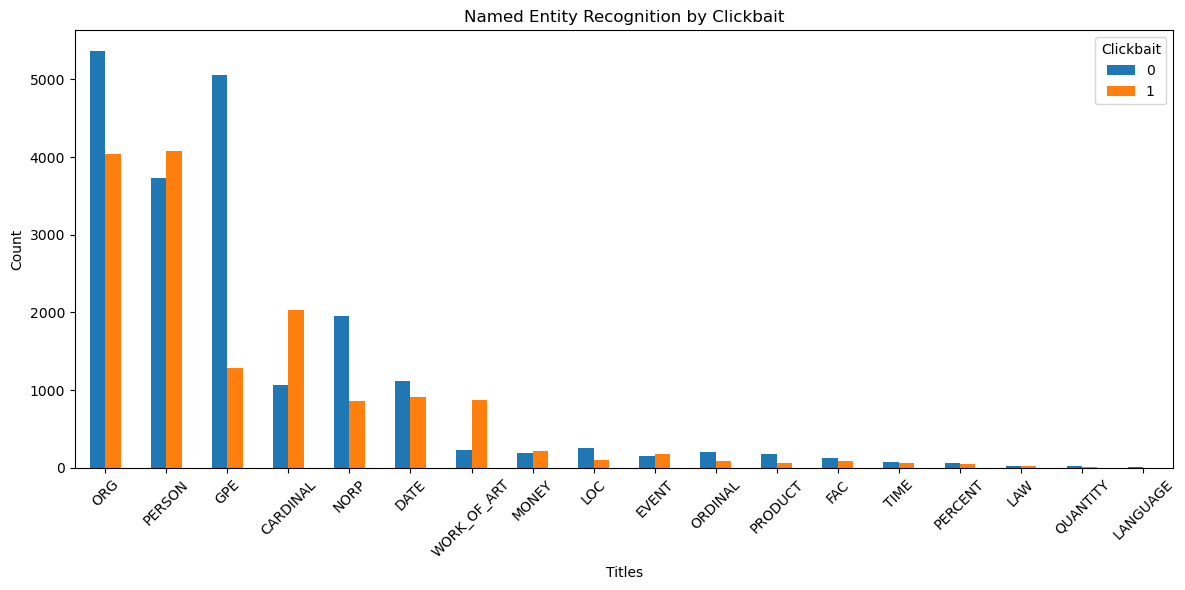

In [164]:
# NER plot
grouped.plot(kind='bar', figsize=(12, 6))
plt.title('Named Entity Recognition by Clickbait')
plt.xlabel('Titles')
plt.ylabel('Count')
plt.legend(title='Clickbait')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

| **Entity**      | **Description**                                                                                  | **Example**                      |
|-----------------|--------------------------------------------------------------------------------------------------|-----------------------------------|
| **ORG**         | Organizations — refers to entities that are organizations such as companies, institutions, or agencies. | Apple, UN                        |
| **GPE**         | Geopolitical Entities — refers to entities that are geographical or political regions such as countries, cities, or states. | USA, Berlin                      |
| **PERSON**      | Person — refers to individual people or characters.                                               | Barack Obama, Elon Musk           |
| **CARDINAL**    | Numerals that do not fall under other numeric types.                                              | three, 1,000                     |
| **NORP**        | Nationalities, religious or political groups.                                                     | American, Christian, Democrat     |
| **PRODUCT**     | Objects, vehicles, foods, etc., that are products.                                                | iPhone, Boeing 737                |
| **DATE**        | Absolute or relative dates or periods.                                                            | July 4th, next week               |
| **ORDINAL**     | First, second, etc.                                                                               | first, third                     |
| **PERCENT**     | Percentage (including the “%” sign).                                                             | 50%, ten percent                 |
| **FAC**         | Facilities — buildings, airports, highways, bridges, etc.                                         | Eiffel Tower, JFK Airport         |
| **EVENT**       | Named events.                                                                                     | Olympics, World War II            |
| **WORK_OF_ART** | Titles of books, songs, etc.                                                                      | The Mona Lisa, The Catcher in the Rye |
| **TIME**        | Times smaller than a day.                                                                         | 2 PM, morning                    |
| **MONEY**       | Monetary values, including unit.                                                                  | $500, €20 million                |
| **LOC**         | Locations that are not geopolitical entities, like mountain ranges, bodies of water, etc.         | Mount Everest, Pacific Ocean      |
| **LAW**         | Named documents made into laws.                                                                   | First Amendment, The Constitution |
| **QUANTITY**    | Measurements, as of weight or distance.                                                           | 7kg, 200 miles                   |
| **LANGUAGE**    | Any named language.                                                                               | English, Spanish                 |